In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluate performance using rmse
from evaluate import get_rmse

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt




In [2]:
df = pd.read_csv('saas.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [3]:
df.describe()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
count,7.904580e+05,7.904580e+05,790458.000000,790458.000000
mean,1.012913e+06,5.395228e+06,0.599235,2.996174
std,7.591992e+03,2.281857e+05,0.950380,4.751901
min,1.000000e+06,5.000000e+06,0.000000,0.000000
25%,1.006405e+06,5.197614e+06,0.000000,0.000000
50%,1.012797e+06,5.395228e+06,0.000000,0.000000
75%,1.019154e+06,5.592843e+06,1.000000,5.000000
max,1.029399e+06,5.790457e+06,4.000000,20.000000


In [6]:
df = df.rename(columns= {'Month_Invoiced': 'month', 'Customer_Id': 'cust_id', 'Invoice_Id': 'inv_id', 'Subscription_Type': 'sub_type', 'Amount': 'amt'})

df.head()

,month,cust_id,inv_id,sub_type,amt
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [7]:
df.sub_type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: sub_type, dtype: int64

In [8]:
df.sub_type = df.sub_type.astype('int64')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   month     790458 non-null  object 
 1   cust_id   790458 non-null  int64  
 2   inv_id    790458 non-null  int64  
 3   sub_type  790458 non-null  int64  
 4   amt       790458 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 30.2+ MB


,month,cust_id,inv_id,sub_type,amt
0,2014-01-31,1000000,5000000,0,0.0
1,2014-01-31,1000001,5000001,2,10.0
2,2014-01-31,1000002,5000002,0,0.0
3,2014-01-31,1000003,5000003,0,0.0
4,2014-01-31,1000004,5000004,1,5.0


In [9]:
# Making decision to look at a reduced dataset of entries with an amount > 0, which appears to be the only continuous variable; reduces row count by almost 500k rows
nonzero_df = df[df.amt > 0]

In [10]:
df.month = pd.to_datetime(df.month)
df = df.set_index(df.month)

nonzero_df.month = pd.to_datetime(nonzero_df.month)
nonzero_df = nonzero_df.set_index(nonzero_df.month)

In [10]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   month     790458 non-null  datetime64[ns]
 1   cust_id   790458 non-null  int64         
 2   inv_id    790458 non-null  int64         
 3   sub_type  790458 non-null  int64         
 4   amt       790458 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 36.2 MB


,month,cust_id,inv_id,sub_type,amt
month,,,,,
2014-01-31,2014-01-31,1000000,5000000,0,0.0
2014-01-31,2014-01-31,1000001,5000001,2,10.0
2014-01-31,2014-01-31,1000002,5000002,0,0.0
2014-01-31,2014-01-31,1000003,5000003,0,0.0
2014-01-31,2014-01-31,1000004,5000004,1,5.0
...,...,...,...,...,...
2017-12-31,2017-12-31,1029395,5790453,0,0.0
2017-12-31,2017-12-31,1029396,5790454,0,0.0
2017-12-31,2017-12-31,1029397,5790455,3,15.0


In [11]:
nonzero_df.info()
nonzero_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 294048 entries, 2014-01-31 to 2017-12-31
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   month     294048 non-null  datetime64[ns]
 1   cust_id   294048 non-null  int64         
 2   inv_id    294048 non-null  int64         
 3   sub_type  294048 non-null  int64         
 4   amt       294048 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 13.5 MB


,month,cust_id,inv_id,sub_type,amt
month,,,,,
2014-01-31,2014-01-31,1000001,5000001,2,10.0
2014-01-31,2014-01-31,1000004,5000004,1,5.0
2014-01-31,2014-01-31,1000005,5000005,2,10.0
2014-01-31,2014-01-31,1000013,5000013,1,5.0
2014-01-31,2014-01-31,1000014,5000014,4,20.0


In [12]:
df = df.drop(columns= ['month'])
df.head()

nonzero_df = nonzero_df.drop(columns= ['month'])
nonzero_df.head()

,cust_id,inv_id,sub_type,amt
month,,,,
2014-01-31,1000001,5000001,2,10.0
2014-01-31,1000004,5000004,1,5.0
2014-01-31,1000005,5000005,2,10.0
2014-01-31,1000013,5000013,1,5.0
2014-01-31,1000014,5000014,4,20.0


In [13]:
df.describe()

,cust_id,inv_id,sub_type,amt
count,7.904580e+05,7.904580e+05,790458.000000,790458.000000
mean,1.012913e+06,5.395228e+06,0.599235,2.996174
std,7.591992e+03,2.281857e+05,0.950380,4.751901
min,1.000000e+06,5.000000e+06,0.000000,0.000000
25%,1.006405e+06,5.197614e+06,0.000000,0.000000
50%,1.012797e+06,5.395228e+06,0.000000,0.000000
75%,1.019154e+06,5.592843e+06,1.000000,5.000000
max,1.029399e+06,5.790457e+06,4.000000,20.000000


In [14]:
nz_train_size = round(len(nonzero_df) * .5)
nz_val_size = round(len(nonzero_df) * .3)
nz_test_size = (len(nonzero_df) - nz_train_size - nz_val_size)

nz_val_end_idx = nz_train_size + nz_val_size

nz_train = nonzero_df[:nz_train_size]
nz_validate = nonzero_df[nz_train_size:nz_val_end_idx]
nz_test = nonzero_df[nz_val_end_idx:]

print(nz_train.shape, nz_validate.shape, nz_test.shape)

(147024, 4) (88214, 4) (58810, 4)


In [15]:
len(nz_train) + len(nz_validate) + len(nz_test) == len(nonzero_df)

True

In [16]:
print(nonzero_df.head(1) == nz_train.head(1))

            cust_id  inv_id  sub_type   amt
month                                      
2014-01-31     True    True      True  True


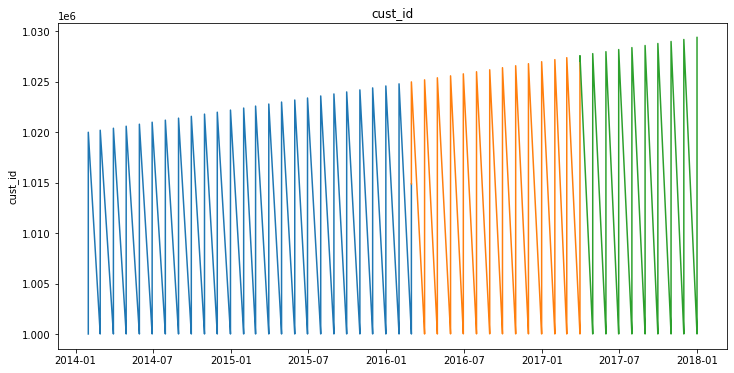

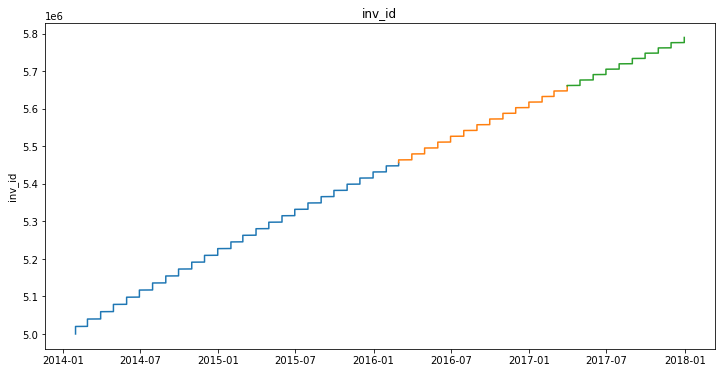

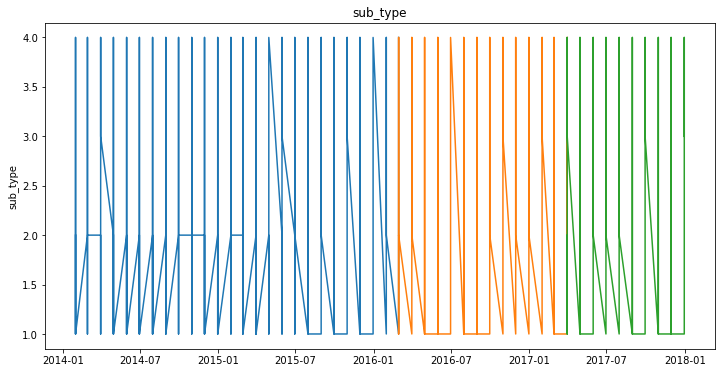

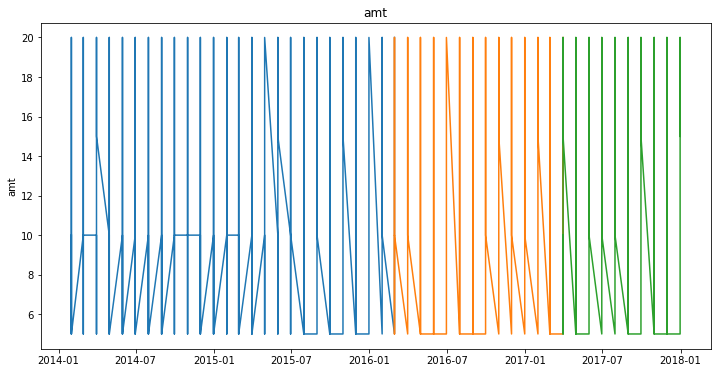

In [17]:
for col in nz_train.columns:
    plt.figure(figsize=(12,6))
    plt.plot(nz_train[col])
    plt.plot(nz_validate[col])
    plt.plot(nz_test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

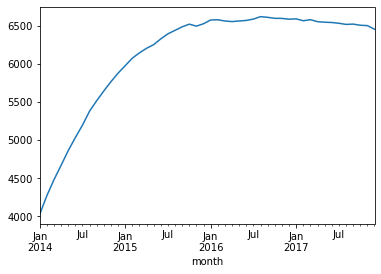

<AxesSubplot:xlabel='month'>

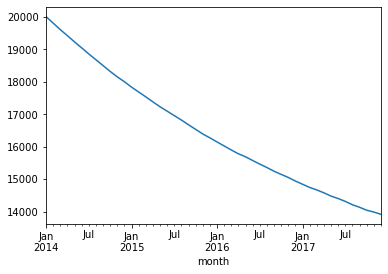

In [28]:
nonzero_df.resample('M').size().plot()
plt.show()
df.resample('M').size().plot()

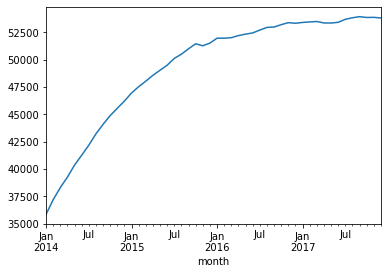

<AxesSubplot:xlabel='month'>

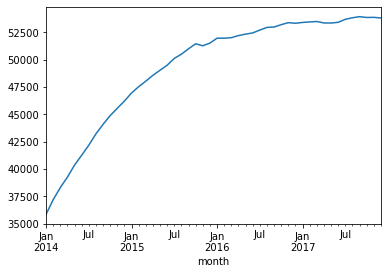

In [29]:
nonzero_df.resample('M').amt.sum().plot()
plt.show()
df.resample('M').amt.sum().plot()

In [31]:
proj_df = df.copy().resample('M')[['amt']].sum()

proj_df

,amt
month,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [32]:
p_train_size = round(len(proj_df) * .5)
p_validate_size = round(len(proj_df) * .3)
p_test_size = (len(proj_df) - p_train_size - p_validate_size)

p_validate_end_idx = p_train_size + p_validate_size
p_train = proj_df[:p_train_size]
p_validate = proj_df[p_train_size:p_validate_end_idx]
p_test = proj_df[p_validate_end_idx:]

print(p_train.shape, p_validate.shape, p_test.shape)

(24, 1) (14, 1) (10, 1)


In [41]:
p_train.columns

Index(['amt'], dtype='object')

Text(0.5, 1.0, 'amt')

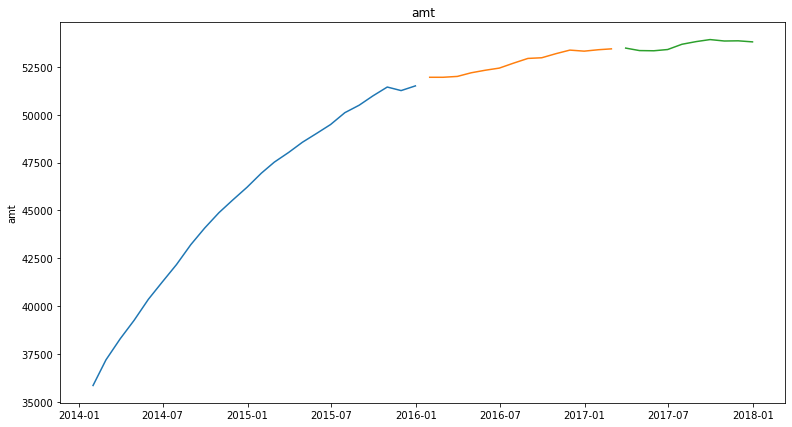

In [36]:

plt.figure(figsize= (13,7))
plt.plot(p_train[col])
plt.plot(p_validate[col])
plt.plot(p_test[col])
plt.ylabel(col)
plt.title(col)
   

In [46]:
def eval_target(target_var):
    '''
    Takes in actual and predicted values of target variable from validate and yhat_df respectively,
    computes and returns RMSE'''
    rmse = get_rmse(p_validate[target_var], yhat_df[target_var])
    return rmse

In [47]:
def plot_eval(target_var):
    '''
    Takes in target variable name, 
    returns plot of actual values on p_train and p_validate, and predicted values from yhat_df for target variable
    '''
    plt.figure(figsize = (13,6))
    plt.plot(p_train[target_var], label='Train', linewidth=1)
    plt.plot(p_validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = eval_target(target_var)
    print(f'{target_var} -- RMSE: {rmse:.0f}')
    plt.show()

In [21]:
eval_df = pd.DataFrame(columns= ['model_type', 'target_var', 'rmse'])


In [48]:
def append_eval_df(model_type, target_var):
    rmse = eval_target(target_var)
    d = {'model_type': [model_type], 'target_var': target_var, 'rmse': rmse}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

In [23]:
eval_df

,model_type,target_var,rmse


### Last Observed Value

In [42]:
amt = p_train.amt[-1:][0]
amt

51505.0

In [44]:
yhat_df = pd.DataFrame({'amt': [amt]}, index=p_validate.index)

yhat_df

,amt
month,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0
2016-06-30,51505.0
2016-07-31,51505.0
2016-08-31,51505.0
2016-09-30,51505.0


In [49]:
eval_target('amt')

1342.6905291774635

amt -- RMSE: 1343


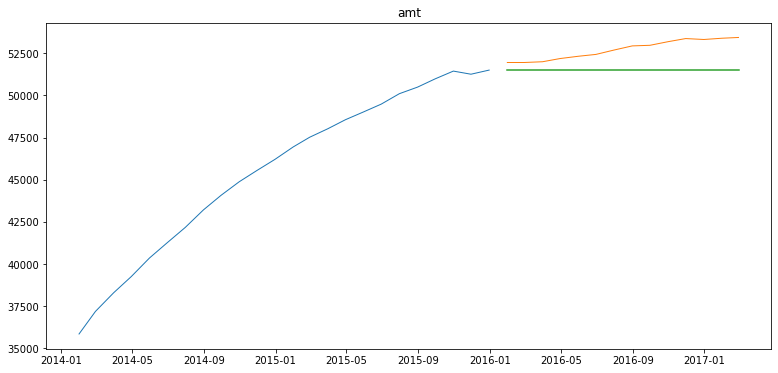

In [50]:
plot_eval('amt')

In [51]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = amt)

eval_df

KeyError: 51505.0